In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 12.0 MB 21.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
!pip install pyLDAvis==3.2.2

     |████████████████████████████████| 1.7 MB 17.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135617 sha256=f33d57d5d380e1701180d0354ecf4fd01da965247fc968dc8db684a67a6b9c67
  Stored in directory: /root/.cache/pip/wheels/f8/b1/9b/560ac1931796b7303f7b517b949d2d31a4fbc512aad3b9f284
Successfully built pyLDAvis


In [3]:
!pip install spacy==2.2.2

     |████████████████████████████████| 10.3 MB 25.6 MB/s 
     |████████████████████████████████| 2.2 MB 40.8 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [4]:
!pip install gensim

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [6]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'add', 'would', 'close', 'list', 'create', 'file', 'basic', 'maintain', 'call', 'set', 'image'])

In [7]:

my_sentences = []
with open('/content/data.txt', 'r', encoding='utf-8', errors='ignore') as filehandle:
    my_sentences = [elements.rstrip().replace('.', '') for elements in filehandle.readlines()]
# Convert to list
data = my_sentences

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'"," ", sent) for sent in data]

pprint(data[:2])

['Enable etcd with security setting',
 'Add new Debian security mirror suite pattern']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])


[['enable', 'etcd', 'with', 'security', 'setting']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['enable', 'etcd', 'with', 'security', 'setting']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['security', 'setting']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [13]:
id2word[0]

'security'

In [14]:
corpus[:1][0][:10]

[(0, 1), (1, 1)]

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('security', 1), ('setting', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.374*"security" + 0.289*"group" + 0.080*"rule" + 0.050*"add" + '
  '0.014*"config" + 0.011*"quota" + 0.011*"request" + 0.011*"validation" + '
  '0.010*"low" + 0.010*"handle"'),
 (1,
  '0.464*"fix" + 0.056*"cento" + 0.046*"merge" + 0.033*"ansible" + '
  '0.029*"local" + 0.015*"phase" + 0.014*"install" + 0.013*"permission" + '
  '0.013*"implicit" + 0.010*"document"'),
 (2,
  '0.282*"update" + 0.099*"guide" + 0.036*"rabbitmq" + 0.027*"image" + '
  '0.023*"project" + 0.023*"table" + 0.021*"instead" + 0.014*"setup" + '
  '0.014*"build" + 0.014*"release"'),
 (3,
  '0.121*"change" + 0.116*"context" + 0.073*"error" + 0.048*"container" + '
  '0.027*"section" + 0.027*"stop" + 0.025*"method" + 0.020*"util" + '
  '0.019*"public" + 0.017*"identity"'),
 (4,
  '0.089*"allow" + 0.056*"neutron" + 0.055*"instance" + 0.046*"case" + '
  '0.036*"auth" + 0.035*"network" + 0.031*"interface" + 0.031*"import" + '
  '0.022*"token" + 0.021*"plugin"'),
 (5,
  '0.064*"server" + 0.055*"policy" + 0.055*"mak

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.853362496749896

Coherence Score:  0.6620996718724103


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.462036  0.021484       1        1  34.610455
13    -0.006133 -0.398745       2        1   6.261928
10    -0.039692  0.027351       3        1   5.810153
9     -0.014353  0.086558       4        1   5.661004
2     -0.034363  0.031241       5        1   5.652612
1     -0.016064  0.042652       6        1   5.618193
6     -0.039567  0.026014       7        1   5.416786
5     -0.047483  0.025807       8        1   5.186357
8     -0.039228  0.034102       9        1   4.971595
4     -0.043173  0.023962      10        1   4.586459
3     -0.043642  0.023238      11        1   4.532476
7     -0.046709  0.034950      12        1   4.061059
11    -0.044731 -0.004169      13        1   3.978692
12    -0.046898  0.025554      14        1   3.652232, topic_info=               Term         Freq        Total Category  logprob  loglift
0          security  1574.000000  1574.000000  Default  30.0000  30.0000
18            group  1214.000000  1214.000000  Default  29.0000  29.0000
75              fix   317.000000   317.000000  Default  28.0000  28.0000
15             test   288.000000   288.000000  Default  27.0000  27.0000
62           update   194.000000   194.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1313  address_group     2.481245     3.367310  Topic14  -5.1858   3.0045
1314        payload     2.481245     3.367310  Topic14  -5.1858   3.0045
1296            edk     2.480070     3.368096  Topic14  -5.1862   3.0038
1297           ovmf     2.480070     3.368096  Topic14  -5.1862   3.0038
1303      readmerst     2.580402     5.881679  Topic14  -5.1466   2.4859

[454 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
60        3  0.892285   ability
351       9  0.898578    access
147       2  0.863604    action
20        1  0.998402       add
1033     13  0.811790  addition
...     ...       ...       ...
230      13  0.863160       wip
816       5  0.913804      word
31        3  0.987658     would
38       14  0.699085     wrong
1403     13  0.901843      zaza

[425 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 14, 11, 10, 3, 2, 7, 6, 9, 5, 4, 8, 12, 13])

In [20]:
pyLDAvis.save_html(vis, 'lda_14.html')

In [23]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2022-05-04 20:42:42--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-05-04 20:42:42--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  60.9MB/s    in 0.3s    

2022-05-04 20:42:43 (60.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [24]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [25]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=100, step=6)

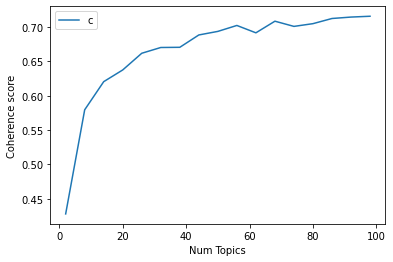

In [28]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4278
Num Topics = 8  has Coherence Value of 0.5796
Num Topics = 14  has Coherence Value of 0.6206
Num Topics = 20  has Coherence Value of 0.6377
Num Topics = 26  has Coherence Value of 0.662
Num Topics = 32  has Coherence Value of 0.6704
Num Topics = 38  has Coherence Value of 0.6707
Num Topics = 44  has Coherence Value of 0.6887
Num Topics = 50  has Coherence Value of 0.6939
Num Topics = 56  has Coherence Value of 0.7025
Num Topics = 62  has Coherence Value of 0.6918
Num Topics = 68  has Coherence Value of 0.7087
Num Topics = 74  has Coherence Value of 0.7011
Num Topics = 80  has Coherence Value of 0.7051
Num Topics = 86  has Coherence Value of 0.7127
Num Topics = 92  has Coherence Value of 0.7147
Num Topics = 98  has Coherence Value of 0.7159


In [30]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.221*"port" + 0.217*"security" + 0.053*"disable" + 0.052*"nsx" + '
  '0.031*"ensure" + 0.029*"deletion" + 0.020*"enable" + 0.020*"section" + '
  '0.020*"setting" + 0.014*"profile"'),
 (1,
  '0.444*"security" + 0.055*"network" + 0.047*"make" + 0.027*"create" + '
  '0.024*"note" + 0.017*"bandit" + 0.015*"resource" + 0.015*"documentation" + '
  '0.013*"protocol" + 0.013*"format"'),
 (2,
  '0.291*"group" + 0.258*"security" + 0.025*"move" + 0.023*"access" + '
  '0.020*"correct" + 0.019*"base" + 0.014*"request" + 0.013*"describe" + '
  '0.013*"event" + 0.012*"manual"'),
 (3,
  '0.359*"rule" + 0.077*"policy" + 0.072*"improve" + 0.041*"handle" + '
  '0.040*"group" + 0.030*"server" + 0.029*"config" + 0.023*"performance" + '
  '0.018*"list" + 0.013*"transaction"'),
 (4,
  '0.314*"test" + 0.072*"change" + 0.061*"delete" + 0.058*"neutron" + '
  '0.045*"modify" + 0.033*"job" + 0.026*"unit" + 0.017*"doc" + 0.017*"api" + '
  '0.016*"driver"'),
 (5,
  '0.253*"update" + 0.127*"guide" + 0.066*"

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.0858,"port, security, disable, nsx, ensure, deletion...",Enable etcd with security setting
1,1,1.0,0.0879,"security, network, make, create, note, bandit,...",Add new Debian security mirror suite pattern
2,2,3.0,0.1032,"rule, policy, improve, handle, group, server, ...",Fix rule replacement in security policy
3,3,7.0,0.1072,"context, security, implement, miss, container,...",OvS: Add pod security context to pods
4,4,3.0,0.0896,"rule, policy, improve, handle, group, server, ...",Horizon: update east-west network security policy
5,5,7.0,0.1377,"context, security, implement, miss, container,...",Add missing security context to Keystone pods/...
6,6,7.0,0.1192,"context, security, implement, miss, container,...",Add missing security context to Mini-mirror te...
7,7,10.0,0.1055,"group, default, remove, rule, driver, role, fa...",Enable setting default rules for default secur...
8,8,8.0,0.0847,"add, security, support, check, type, firewall,...",Testingrst misses a step for adding security rule
9,9,4.0,0.0863,"test, change, delete, neutron, modify, job, un...",Test security groups


In [32]:
df_dominant_topic.to_csv('df_dominant_topic.csv', encoding='utf-8')

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3002,"group, security, instance, table, parameter, s...",Improve styling for security group detail tabl...
1,1.0,0.6690,"change, user, update, patch, fix, issue, close...",Fix security issues with EC2 credentials This ...
2,2.0,0.2660,"support, neutron, network, service, enable, dr...",Add security service update for in-use share n...
3,3.0,0.3075,"fix, check, bug, case, guide, error, fail, exc...",handle not found exceptions from security gr...
4,4.0,0.4374,"security, add, change, patch, code, improve, n...",Improve security defenses at compile level Thi...


In [ ]:

df_dominant_topic.to_csv('sent_topics_sorteddf_mallet.csv', encoding='utf-8')

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Sentences', 'Perc_Sentences']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Sentences,Perc_Sentences
0.0,12.0,"sign, run, apply, openstack, job, depend, conf...",207.0,0.0673
1.0,11.0,"test, change, unit, ad, provide, move, https, ...",121.0,0.0393
2.0,8.0,"security, group, relate, exist, extension, int...",231.0,0.0751
3.0,5.0,"security, add, context, change, server, implem...",242.0,0.0787
4.0,7.0,"change, update, policy, make, description, obj...",160.0,0.0520
5.0,5.0,"security, add, context, change, server, implem...",251.0,0.0816
6.0,5.0,"security, add, context, change, server, implem...",269.0,0.0875
7.0,6.0,"rule, group, default, create, security, method...",228.0,0.0741
8.0,13.0,"bug, close, commit, bf, fix, related, partial,...",169.0,0.0550
9.0,11.0,"test, change, unit, ad, provide, move, https, ...",230.0,0.0748


In [ ]:
df_dominant_topics.to_csv('df_dominant_topics.csv', encoding='utf-8')